# Winning the Jeopardy


Jeopardy is a popular TV show in the US where participants answer questions to win money. In this project, we will work with the dataset of Jeopardy questions to figure out some patterns in the questions that could help win the game.

Each row in the dataset corresponds to one questions asked on a single episode. Description of a few columns :

* **Show Number** - the Jeopardy episode number of the show this question was in.
* **Air Date** - the date the episode aired.
* **Round** - the round of Jeopardy that the question was asked in. Jeopardy has several rounds as each episode progresses.
* **Category** - the category of the question.
* **Value** - the number of dollars answering the question correctly is worth.
* **Question** - the text of the question.
* **Answer** - the text of the answer.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import bigrams
from scipy.stats import chisquare,chi2_contingency
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\14CK0013LA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\14CK0013LA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_csv('jeopardy.csv')
df.head(5)

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [3]:
df.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

We will firstly clean the column names for our ease of usage throughout the project.

In [4]:
cols=df.columns
cols=cols.str.strip().str.lower().str.replace(" ","_")
df.columns=cols
df.head()

,show_number,air_date,round,category,value,question,answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


Now we'll analyze the data schema

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   show_number  19999 non-null  int64 
 1   air_date     19999 non-null  object
 2   round        19999 non-null  object
 3   category     19999 non-null  object
 4   value        19999 non-null  object
 5   question     19999 non-null  object
 6   answer       19999 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.1+ MB


## 1. Normalization

Let us normalize the text columns.

### a. First we'll normalize 'Value' column

In [6]:
df['value'].unique()

array(['$200', '$400', '$600', '$800', '$2,000', '$1000', '$1200',
       '$1600', '$2000', '$3,200', 'None', '$5,000', '$100', '$300',
       '$500', '$1,000', '$1,500', '$1,200', '$4,800', '$1,800', '$1,100',
       '$2,200', '$3,400', '$3,000', '$4,000', '$1,600', '$6,800',
       '$1,900', '$3,100', '$700', '$1,400', '$2,800', '$8,000', '$6,000',
       '$2,400', '$12,000', '$3,800', '$2,500', '$6,200', '$10,000',
       '$7,000', '$1,492', '$7,400', '$1,300', '$7,200', '$2,600',
       '$3,300', '$5,400', '$4,500', '$2,100', '$900', '$3,600', '$2,127',
       '$367', '$4,400', '$3,500', '$2,900', '$3,900', '$4,100', '$4,600',
       '$10,800', '$2,300', '$5,600', '$1,111', '$8,200', '$5,800',
       '$750', '$7,500', '$1,700', '$9,000', '$6,100', '$1,020', '$4,700',
       '$2,021', '$5,200', '$3,389'], dtype=object)

In [7]:
df['value'].fillna(value=np.nan, inplace=True)
df.rename({'value':'value_$'},axis=1,inplace=True)
df['value_$']=df['value_$'].str.replace('$','').str.replace(',','')
df['value_$']=pd.to_numeric(df['value_$'], errors='coerce')
df.head()


,show_number,air_date,round,category,value_$,question,answer
0,4680,2004-12-31,Jeopardy!,HISTORY,200.0,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200.0,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200.0,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,200.0,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,200.0,"Signer of the Dec. of Indep., framer of the Co...",John Adams


### b. Text columns

Before we can start doing analysis on the Jeopardy questions, we need to normalize all of the text columns (the Question and Answer columns). The idea is to ensure that we lowercase words and remove punctuation so Don't and don't aren't considered to be different words when you compare them. .

In [8]:
def normalization(string):
    string=string.lower()
    string=re.sub(r'[^\w\s]', '', string)
    return string

df['clean_question']=df['question'].apply(normalization)
df['clean_answer']=df['answer'].apply(normalization)
df.head()

,show_number,air_date,round,category,value_$,question,answer,clean_question,clean_answer
0,4680,2004-12-31,Jeopardy!,HISTORY,200.0,"For the last 8 years of his life, Galileo was ...",Copernicus,for the last 8 years of his life galileo was u...,copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200.0,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,no 2 1912 olympian football star at carlisle i...,jim thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200.0,The city of Yuma in this state has a record av...,Arizona,the city of yuma in this state has a record av...,arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,200.0,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,in 1963 live on the art linkletter show this c...,mcdonalds
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,200.0,"Signer of the Dec. of Indep., framer of the Co...",John Adams,signer of the dec of indep framer of the const...,john adams


### c. The Air Date column should also be a datetime, not a string, to enable us to work with it more easily.

In [9]:
df['air_date'] = pd.to_datetime(df['air_date'],format='%Y-%m-%d')
print(df.info())
print('\n')
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   show_number     19999 non-null  int64         
 1   air_date        19999 non-null  datetime64[ns]
 2   round           19999 non-null  object        
 3   category        19999 non-null  object        
 4   value_$         19663 non-null  float64       
 5   question        19999 non-null  object        
 6   answer          19999 non-null  object        
 7   clean_question  19999 non-null  object        
 8   clean_answer    19999 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 1.4+ MB
None




,show_number,air_date,round,category,value_$,question,answer,clean_question,clean_answer
0,4680,2004-12-31,Jeopardy!,HISTORY,200.0,"For the last 8 years of his life, Galileo was ...",Copernicus,for the last 8 years of his life galileo was u...,copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200.0,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,no 2 1912 olympian football star at carlisle i...,jim thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200.0,The city of Yuma in this state has a record av...,Arizona,the city of yuma in this state has a record av...,arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,200.0,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,in 1963 live on the art linkletter show this c...,mcdonalds
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,200.0,"Signer of the Dec. of Indep., framer of the Co...",John Adams,signer of the dec of indep framer of the const...,john adams


## 2. Analyzing the game

In order to figure out whether to study past questions, study general knowledge, or not study it all, it would be helpful to figure out two things:

* How often the answer is deducible from the question.
* How often new questions are repeats of older questions.

**a. We can answer the first question by seeing how many times words in the answer also occur in the question**

In [10]:
def answer_deducible_from_question(row):
    split_answer= row['clean_answer'].split()
    split_question= row['clean_question'].split()
    match_count=0
    
    split_question_no_stopwords = [
        word for word in split_question if not word in stopwords.words('english')
    ]
    split_answer_no_stopwords = [
        word for word in split_answer if not word in stopwords.words('english')
    ]
    
    if len(split_answer_no_stopwords)==0:
        return 0
    
    for word in split_answer_no_stopwords:
        if word in split_question_no_stopwords:
            match_count+=1
    return match_count/len(split_answer_no_stopwords)
        
df['answer_in_question']=df.apply(answer_deducible_from_question,axis=1)  
df['answer_in_question'].value_counts(normalize=True)

0.000000    0.925246
0.500000    0.051503
0.333333    0.010401
1.000000    0.006750
0.250000    0.002250
0.666667    0.002050
0.200000    0.000800
0.750000    0.000250
0.142857    0.000200
0.166667    0.000150
0.400000    0.000100
0.222222    0.000050
0.125000    0.000050
0.071429    0.000050
0.833333    0.000050
0.111111    0.000050
0.090909    0.000050
Name: answer_in_question, dtype: float64

In [11]:
df['answer_in_question'].mean()

0.038411525554632744

We found the mean to be ~ 4%
This is actually a very small proportion (only 4.0%) of questions that contain some part of the answer in them. This tells us that just by this idea, we cannot win Jeopardy.

Lets now try to see how often new questions are repeat of older ones. Now the dataset(sample) we are working with is just a representative of the population, hence we can only investigate this phenomenon and try to generalize it.

**b. How often questions are repeats of older ones?**

In [20]:
questions_overlap = []
words_used = set()

df = df.sort_values(by='air_date')

for i, row in df.iterrows():
        split_question = row["clean_question"].split(" ")
        split_question_no_stopwords = [
        word for word in split_question if not word in stopwords.words('english')]
    
        match_count = 0
        for word in split_question_no_stopwords:
            if word in words_used:
                match_count += 1
            words_used.add(word)
        if len(split_question_no_stopwords) > 0:
            match_count /= len(split_question_no_stopwords)
        questions_overlap.append(match_count)
        
df["questions_overlap"] = questions_overlap

df["questions_overlap"].mean()

0.7980683550294374

The percentage is around ~ 80%. This is a considerable amount but we are only considering unigrams. This high percentage can be because certain words repeat multiple times but not neccessarily in the same context.

To gain more insight let us plot a wordcloud to understand which words are most frequent in questions. This might tell us why the percentage came out to be so high.

(-0.5, 1199.5, 799.5, -0.5)

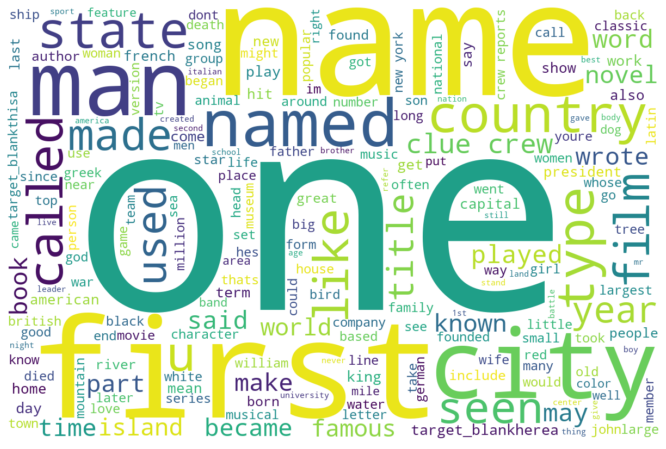

In [26]:
text = ""

for question in df.clean_question:
    text = text + question + " "
    
wordcloud = WordCloud(
    width=1200,
    height=800,
    stopwords=stopwords.words('english'),
    background_color='white'
).generate(text)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

The most common words from the wordcloud are non contextual i.e. they can be used in any type of question irrespective of the context of the question. These results make it a compelling reason to look into bigrams or phrazes to further analyze this point.

In [27]:
questions_overlap = []
phrase_used = set()
phrase_frequency = {}

for i, row in df.iterrows():
        split_question = row["clean_question"].split(" ")
        split_question_no_stopwords = [
        word for word in split_question if not word in stopwords.words('english')]
        
        phrases = list(bigrams(split_question_no_stopwords))
        match_count = 0
        
        for phrase in phrases:
            key = " ".join(phrase)
            if phrase in phrase_used:
                match_count += 1
                phrase_frequency[key] += 1
            else:
                phrase_frequency[key] = 1
            phrase_used.add(phrase)
            
        if len(split_question_no_stopwords) > 1:
            match_count /= len(split_question_no_stopwords)
        questions_overlap.append(match_count)
        
df["phrases_questions_overlap"] = questions_overlap

df["phrases_questions_overlap"].mean()

0.10347068862952474

We see our findings to be completely different from what we acheived previously in terms of unigrams. As we cited before, single words may appear multiple times but not neccessarily in the same context.

With bigrams, we partially considered (though not completely) meaning/context of some words appearing together in the questions. Just changing from unigrams to bigrams, there was a significant drop in the percentage of overlap in questions, about ~ 10.35% and even then this is just the proxy/estimate and not the real story.

Let us visualize the frequent bigrams via a wordcloud.

(-0.5, 1199.5, 799.5, -0.5)

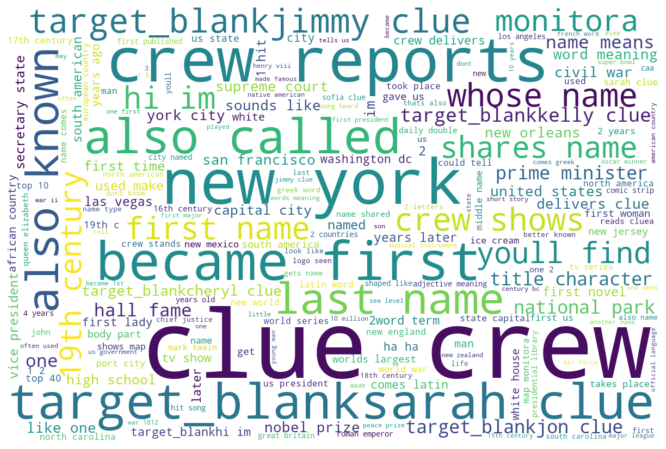

In [28]:
wordcloud = WordCloud(
    width=1200,
    height=800,
    background_color='white'
).generate_from_frequencies(phrase_frequency)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

Even though the bigrams gave a bit of context into the questions, we can see from the wordcloud, that bigrams are still not a perfect representation of the context of the questions and thus only show partially the repeatition of questions on the show.

The game is all about answering questions and earning money for every correct answer. So let us try to seggregate our analysis into high value questions and low value questions.

Let us consider a threshold for high and low separation.

## 3. High value questions instead of low value questions

We can actually figure out which terms correspond to high-value questions using a chi-squared test. We'll first need to narrow down the questions into two categories:

* Low value -- Any row where Value is less than 'value' column mean.
* High value -- Any row where Value is greater than value' column mean.
We'll then be able to loop through each of the terms from the last screen, terms_used, and:

1. Find the number of low value questions the word occurs in.
2. Find the number of high value questions the word occurs in.
3. Find the percentage of questions the word occurs in.
4. Based on the percentage of questions the word occurs in, find expected counts.
5. Compute the chi squared value based on the expected counts and the observed counts for high and low value questions

In [32]:
df['value_$'].describe()

count    19663.000000
mean       761.123786
std        652.132048
min        100.000000
25%        400.000000
50%        600.000000
75%       1000.000000
max      12000.000000
Name: value_$, dtype: float64

The mean is at 761.123786. Rounding it to 760 looks like a good threshold.

In [33]:
df['high_value']=np.where(df['value_$']>760,1,0)
df.head()

,show_number,air_date,round,category,value_$,question,answer,clean_question,clean_answer,answer_in_question,questions_overlap,phrases_questions_overlap,high_value
19325,10,1984-09-21,Final Jeopardy!,U.S. PRESIDENTS,NaN,"Adventurous 26th president, he was 1st to ride...",Theodore Roosevelt,adventurous 26th president he was 1st to ride ...,theodore roosevelt,0.0,0.000000,0.0,0
19280,10,1984-09-21,Jeopardy!,GEOGRAPHY,200.0,Dutch is still an official language in what is...,Dutch Guiana,dutch is still an official language in what is...,dutch guiana,0.5,0.000000,0.0,0
19286,10,1984-09-21,Jeopardy!,DOUBLE TALK,300.0,Adopted baby of Barney & Betty Rubble,Bamm-Bamm,adopted baby of barney betty rubble,bammbamm,0.0,0.166667,0.0,0
19285,10,1984-09-21,Jeopardy!,GEOGRAPHY,300.0,"8th most populous country in the world, this ""...",Bangladesh,8th most populous country in the world this be...,bangladesh,0.0,0.000000,0.0,0
19324,10,1984-09-21,Double Jeopardy!,TV TRIVIA,1000.0,"In court, he'd always make mincemeat of Hamilt...",Perry Mason,in court hed always make mincemeat of hamilton...,perry mason,0.0,0.000000,0.0,1


Now, we can observe the frequency of the terms for high and low value questions.

In [34]:
import random

def low_high_count(word):
    low_count=0
    high_count=0
    for i,row in df.iterrows():
        split_question=row['clean_question'].split()
        if word in split_question:
            if row['high_value']==1:
                high_count+=1
            else:
                low_count+=1
    return high_count,low_count

Let us apply the function for the first 5 words present in the set as a test.

In [40]:
comparison_terms=pd.Series(list(words_used)).sample(5,random_state=2)
observed_expected=[]

for row in comparison_terms:
    observed_expected.append(low_high_count(row))
    
print(observed_expected)

[(0, 3), (1, 0), (1, 0), (1, 2), (1, 0)]


In [41]:
comparison_terms

16597      outbreak
8751         halved
4251     abdication
12399         andys
9984        varnish
dtype: object

Now we write a function that calculates the expected values for these observed values. The logic behind is straight forward. For each word,

* expected_high = (high_count + low_count / total rows) number of rows with high_value 1
* expected_low = (high_count + low_count / total rows) number of rows with high_value 0

Once we have these observed and expected values, for each word in our test set of 5 words, we will perform a chi-square test to find statistical significance.
The null hypothesis is that there is no statistical significance between the two groups - high and low with respect to the word.
The alternative hypothesis is that there exists some significance in the relationship of a word to the two groups - high and low

In short what we are looking for, is to understand if the words in the questions can lead us to identify whether the question is of high-value or low-value (>760 or <=760 dollars).

In [45]:
high_value_count=df['high_value'].value_counts()[1]
low_value_count=df['high_value'].value_counts()[0]

print(high_value_count,low_value_count)

8714 11285


In [46]:
from scipy.stats import chisquare

chi_squared = {}

def chi_test(observed_expected,comparison_terms):
    for word,obs in zip(comparison_terms,observed_expected):
        total = sum(obs)
        total_prop = total / df.shape[0]
        high_value_exp = total_prop * high_value_count
        low_value_exp = total_prop * low_value_count

        observed = np.array([obs[0], obs[1]])
        expected = np.array([high_value_exp, low_value_exp])
        chi_squared[word] = chisquare(observed,expected)

chi_test(observed_expected,comparison_terms)
chi_squared

{'outbreak': Power_divergenceResult(statistic=2.316526362428002, pvalue=0.1280055936954965),
 'halved': Power_divergenceResult(statistic=1.295042460408538, pvalue=0.2551207647961051),
 'abdication': Power_divergenceResult(statistic=1.295042460408538, pvalue=0.2551207647961051),
 'andys': Power_divergenceResult(statistic=0.1279147589930691, pvalue=0.7206039615746844),
 'varnish': Power_divergenceResult(statistic=1.295042460408538, pvalue=0.2551207647961051)}

For every word, the p-value is much higher than the threshold - 0.05. Hence we fail to reject the null hypothesis. This means that by examining these 5 words, we found no statistical significance suggesting that these words can help us identify the type of question (high-value or low-value) we are dealing with.

The above result is only for 5 terms, and maybe inconclusive of the bigger picture. Thus let us try it again with more words.

In [47]:
observed_expected = []
comparison_terms = pd.Series(list(words_used)).sample(15,random_state=4)

for word in comparison_terms:
    observed_expected.append(low_high_count(word))
print(observed_expected)
comparison_terms

[(22, 24), (2, 1), (0, 3), (0, 1), (1, 3), (3, 0), (0, 1), (0, 1), (3, 6), (1, 0), (14, 26), (1, 0), (1, 1), (1, 3), (0, 1)]


203           ever
31410      bahamas
12322        pongo
13953      hickoks
11906        lotus
1034          laba
21588     carraway
2901          swab
7742      headline
12543         tole
19398         1978
16324       beamed
19049        beryl
9440      interred
15225    ownership
dtype: object

In [48]:
chi_squared = {}
chi_test(observed_expected,comparison_terms)
chi_squared

{'ever': Power_divergenceResult(statistic=0.3385567918241026, pvalue=0.5606634559175969),
 'bahamas': Power_divergenceResult(statistic=0.6507817652589396, pvalue=0.4198333166987812),
 'pongo': Power_divergenceResult(statistic=2.316526362428002, pvalue=0.1280055936954965),
 'hickoks': Power_divergenceResult(statistic=0.7721754541426672, pvalue=0.3795448984353684),
 'lotus': Power_divergenceResult(statistic=0.5611553869231358, pvalue=0.4537950938863936),
 'laba': Power_divergenceResult(statistic=3.8851273812256135, pvalue=0.04871556686149284),
 'carraway': Power_divergenceResult(statistic=0.7721754541426672, pvalue=0.3795448984353684),
 'swab': Power_divergenceResult(statistic=0.7721754541426672, pvalue=0.3795448984353684),
 'headline': Power_divergenceResult(statistic=0.383744276979207, pvalue=0.5356061434563664),
 'tole': Power_divergenceResult(statistic=1.295042460408538, pvalue=0.2551207647961051),
 '1978': Power_divergenceResult(statistic=1.195473231012913, pvalue=0.2742283143230177

For these 15 terms, the results look pretty much the same and they don't seem to show any correlation that a word helps identifying the group (high-value or low-value) of the question.

Since checking value_level with words was a dead end, let us try to analyze a relationship that might be simpler. The rounds column gives us the 4 rounds the game hosts.

In [49]:
df['round'].value_counts()

Jeopardy!           9901
Double Jeopardy!    9762
Final Jeopardy!      335
Tiebreaker             1
Name: round, dtype: int64

Looking at the data and making its cross table with the value_level column, we can tell that Doube Jeopardy round holds the most high-value questions. But how do we know whether this phenomenon if just by chance (for this sample) or is this true for the population.

In [50]:
cross_table = pd.crosstab(df['round'],df['high_value'])
cross_table

high_value,0,1
round,,
Double Jeopardy!,3507,6255
Final Jeopardy!,335,0
Jeopardy!,7442,2459
Tiebreaker,1,0


For this purpose, let us perform a chi-square test using the scipy.stats.chi2_contingency function on the cross table.
The null hypothesis is that there is no correlation between the rounds and the value level of the questions.
The alternative hypothesis is that there exists some correlation between the rounds and value level of the questions.

In [51]:
chi_sq,p_value,dof,expected = chi2_contingency(cross_table)
p_value

0.0

A p_value rounded to 0.0 means we can reject the null hypothesis, and can assume the alternate hypothesis to be true i.e. there exists a correlation between the rounds and value level of the questions.

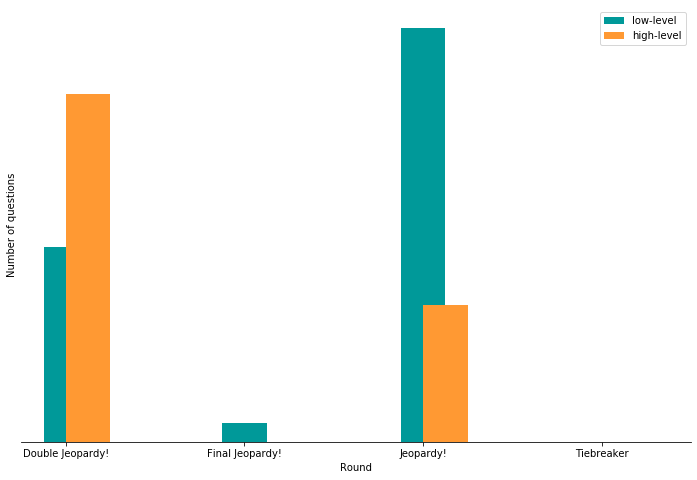

In [52]:
plt.figure(figsize=(12,8))
cross_table[0].plot.bar(align='center',color='#009999',label='low-level',width=0.25)
cross_table[1].plot.bar(align='edge',color = '#ff9933',label='high-level',width=0.25)
plt.legend()
plt.yticks([])
plt.xticks(rotation=0)
plt.ylabel('Number of questions')
plt.xlabel('Round')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

Looking at the cross table and the plot, we can then conclude the direction of the difference i.e. The first round Jeopardy hosts more low-level questions whereas the second round Double Jeopardy hosts more high-level questions. The final round Final Jeopardy and the Tiebreaker round host more of low-level questions.

The category column has the topic for the question. We have analysed which rounds have a higher chance of having high-value questions. Now let us look into the categories (topics) and its correlation with the value levels. This was we can have an idea whether there exists a relationship/correlation between the value level and topic of question.

In [53]:
df.category.value_counts()

TELEVISION                        51
U.S. GEOGRAPHY                    50
LITERATURE                        45
HISTORY                           40
AMERICAN HISTORY                  40
                                  ..
ALL GOD'S CREATURES                1
AFTER THE PRESIDENCY               1
MOVIES & DANCE                     1
PULITZER PRIZE-WINNING BOOKS       1
HISTORIC PROPERTY TRANSACTIONS     1
Name: category, Length: 3581, dtype: int64

Similar to the approach in finding the correlation between the words and value level of the questions. We will find the observed and expected frequencies of high-value and low-value questions for each category, to this we will apply a chi-square test to determine.

The null hypothesis is that there is no correlation between the level of the value and the topic of the question.
The alternative hypothesis is that there is a correlation between the level of the value and the topic of the question.

In simple words we are checking for each category whether it is associated mostly with high-level questions or low-level questions. We will perform this analysis on the top 10 frequent topics in the sample data.

In [54]:
catgs = df.category.value_counts().sort_values(ascending=False)[:10].index

def observed(catg):
    high_count = 0
    low_count = 0
    
    for i,row in df.iterrows():
        if row.category == catg:
            if row['high_value'] == 1:
                high_count += 1
            else:
                low_count += 1
                
    return high_count,low_count

observed_values = []
for catg in catgs:
    observed_values.append(observed(catg))
    
observed_values

[(9, 42),
 (20, 30),
 (21, 24),
 (12, 28),
 (18, 22),
 (24, 16),
 (12, 27),
 (15, 23),
 (14, 23),
 (10, 26)]

In [55]:
chi_squared = {}

chi_test(observed_values,catgs)
chi_squared

{'TELEVISION': Power_divergenceResult(statistic=13.941489027465813, pvalue=0.00018858955620803958),
 'U.S. GEOGRAPHY': Power_divergenceResult(statistic=0.25949785783631446, pvalue=0.6104653431793821),
 'LITERATURE': Power_divergenceResult(statistic=0.17526192502981316, pvalue=0.6754770906301193),
 'HISTORY': Power_divergenceResult(statistic=2.9967917586670154, pvalue=0.08342957570170428),
 'AMERICAN HISTORY': Power_divergenceResult(statistic=0.03316692443543142, pvalue=0.855490212383109),
 'BEFORE & AFTER': Power_divergenceResult(statistic=4.390534336396016, pvalue=0.03613898538801975),
 'AUTHORS': Power_divergenceResult(statistic=2.6000518043290746, pvalue=0.10686022199140573),
 'WORD ORIGINS': Power_divergenceResult(statistic=0.2596149692997901, pvalue=0.6103847994683275),
 'WORLD CAPITALS': Power_divergenceResult(statistic=0.4948415535552552, pvalue=0.4817755106192815),
 'BODIES OF WATER': Power_divergenceResult(statistic=3.652634806702691, pvalue=0.05598058556613405)}

Here we can see the majority of topics do not have p_value <= 0.05, meaning for these topics we fail to reject the null hypothesis. However, for two topics - TELEVISION and BEFORE & AFTER, the null hypothesis is rejected and hence can be said that it does have a correlation with the value levels.

We have only performed these tests for the top 10 most frequent categories (topics) in the data. Let us perform the same for the top 20 categories (topics).

In [56]:
catgs = df.category.value_counts().sort_values(ascending=False)[:20].index

observed_values = []
for catg in catgs:
    observed_values.append(observed(catg))
    
print(catgs)
observed_values

Index(['TELEVISION', 'U.S. GEOGRAPHY', 'LITERATURE', 'HISTORY',
       'AMERICAN HISTORY', 'BEFORE & AFTER', 'AUTHORS', 'WORD ORIGINS',
       'WORLD CAPITALS', 'BODIES OF WATER', 'SPORTS', 'SCIENCE & NATURE',
       'SCIENCE', 'MAGAZINES', 'RHYME TIME', 'WORLD GEOGRAPHY',
       'ANNUAL EVENTS', 'WORLD HISTORY', 'HISTORIC NAMES',
       'IN THE DICTIONARY'],
      dtype='object')


[(9, 42),
 (20, 30),
 (21, 24),
 (12, 28),
 (18, 22),
 (24, 16),
 (12, 27),
 (15, 23),
 (14, 23),
 (10, 26),
 (7, 29),
 (21, 14),
 (21, 14),
 (12, 23),
 (12, 23),
 (11, 22),
 (11, 21),
 (10, 22),
 (15, 17),
 (22, 9)]

In [57]:
chi_squared = {}
chi_test(observed_values,catgs)
chi_squared

{'TELEVISION': Power_divergenceResult(statistic=13.941489027465813, pvalue=0.00018858955620803958),
 'U.S. GEOGRAPHY': Power_divergenceResult(statistic=0.25949785783631446, pvalue=0.6104653431793821),
 'LITERATURE': Power_divergenceResult(statistic=0.17526192502981316, pvalue=0.6754770906301193),
 'HISTORY': Power_divergenceResult(statistic=2.9967917586670154, pvalue=0.08342957570170428),
 'AMERICAN HISTORY': Power_divergenceResult(statistic=0.03316692443543142, pvalue=0.855490212383109),
 'BEFORE & AFTER': Power_divergenceResult(statistic=4.390534336396016, pvalue=0.03613898538801975),
 'AUTHORS': Power_divergenceResult(statistic=2.6000518043290746, pvalue=0.10686022199140573),
 'WORD ORIGINS': Power_divergenceResult(statistic=0.2596149692997901, pvalue=0.6103847994683275),
 'WORLD CAPITALS': Power_divergenceResult(statistic=0.4948415535552552, pvalue=0.4817755106192815),
 'BODIES OF WATER': Power_divergenceResult(statistic=3.652634806702691, pvalue=0.05598058556613405),
 'SPORTS': Po

We have new additions to our list of topics that have correlation with the value levels, they are - SPORTS, SCIENCE, SCIENCE & NATURE, BIRDS and the ones from previous analysis as well as this, TELEVISION and BEFORE & AFTER.

Let us make a cross table for these topics, to understand the frequencies of these topics with respect to the value level.

In [63]:
catg_interest = [
    'SPORTS',
    'SCIENCE',
    'SCIENCE & NATURE',
    'BIRDS',
    'TELEVISION',
    'BEFORE & AFTER'
]

subset = df[df.category.isin(catg_interest)]
cross_table = pd.crosstab(subset['category'],subset['high_value'])
cross_table

high_value,0,1
category,,
BEFORE & AFTER,16,24
BIRDS,26,5
SCIENCE,14,21
SCIENCE & NATURE,14,21
SPORTS,29,7
TELEVISION,42,9


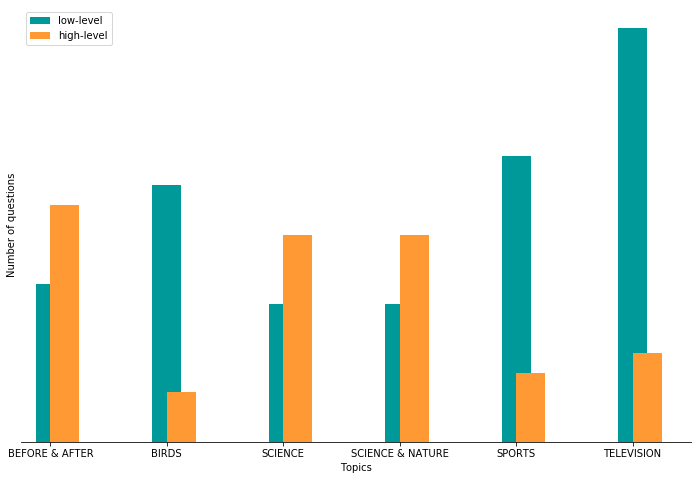

In [64]:
plt.figure(figsize=(12,8))
cross_table[0].plot.bar(align='center',color='#009999',label='low-level',width=0.25)
cross_table[1].plot.bar(align='edge',color = '#ff9933',label='high-level',width=0.25)
plt.legend()
plt.yticks([])
plt.xticks(rotation=0)
plt.ylabel('Number of questions')
plt.xlabel('Topics')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

Looking into the cross table, the plot and the p_values obtained from before, we can say that the topics SPORTS, TELEVISION, BIRDS have a higher chance of being low-level questions, whereas the topics BEFORE & AFTER, SCIENCE and SCIENCE & NATURE have a higher chance of being high-level questions.

From our analysis, we can conclude :-

1. The answers are hardly hidden in the questions and hence the participant has to be revised with all categories (topics).

2. The repetition of questions is rare, the participant must not rely on reading previous questions only to win the game.

3. No relationship was found between the level of the question (>760 or <760 dollars) and the words present in the questions. Thus the participant cannot estimate the level of the question with respect to words in  the question.

4. The first round, Jeopardy! hosts mostly low-level (<760 dollars) questions. Whereas the second round    Double Jeopardy! hosts high-level (>760 dollars) questions. Participant's aim to win more money can utilize these findings and play accordingly.

5. The categories (topics) - SPORTS, TELEVISION and BIRDS have a higher chance of having low-level (<760 dollars) questions, whereas the categories (topics) BEFORE & AFTER, SCIENCE and SCIENCE & NATURE have a highe chance of having high-level (> 760 dollars) questions. 

From the above conclusions, the participant can accordingly prepare and choose to answer questions in the game in order to win more money and overall be successful in the game.